# Task
Load the Parquet Files

## Load the specified parquet file

### Subtask:
Convert from bytes to pixel brightness



**Reasoning**:
Update the file path in the existing code cell to load the specified parquet file and execute the cell.



## Inspect the dataframe

### Subtask:
Save to pandas df



**Reasoning**:
Display the column names, data types, and first few rows of the DataFrame to understand its structure and the nature of the image data.



## Extract and display images

### Subtask:
Based on the DataFrame structure, write code to extract the image data (e.g., if it's in a specific column) and display the images. This might require using libraries like Pillow or OpenCV.


**Reasoning**:
Import PIL and iterate through the first few rows of the dataframe to extract and display the images.



In [5]:
# Ensure pyarrow is installed in this kernel
!pip install --quiet pyarrow
!pip install pandas Pillow kagglehub ipywidgets numpy matplotlib pyarrow


In [6]:

import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt


In [7]:
import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt

# Ensure a 'data' directory exists for the parquet files
if not os.path.exists('data'):
    os.makedirs('data')

# Load parquet files
# Make sure to reference download instructions. You have to download the kaggle dataset and upload it, rename it to a data directory. Video guide coming soon
#from: https://drive.google.com/drive/folders/12-1XR8df-rYkwJuMqMgXYQ9dm6EoDx0f?usp=drive_link
#quickstart guide: https://www.youtube.com/watch?v=WPRarAeelAM
#Original source + description: https://advp.niagads.org/downloads
train_df = pd.read_parquet("data/train.parquet")
test_df  = pd.read_parquet("data/test.parquet")

def bytes_to_pixels(b: bytes) -> np.ndarray:
    """
    Convert raw image bytes (e.g. JPEG/PNG) into a 2D numpy array of pixel values (grayscale).
    """
    img = Image.open(io.BytesIO(b))  # convert to grayscale
    return np.array(img)
def extract_bytes(blob):
    """
    Unwrap a dict‐wrapped binary payload if needed,
    otherwise return blob directly.
    """
    if isinstance(blob, dict):
        # try common keys
        for key in ("bytes", "data", "image"):
            if key in blob and isinstance(blob[key], (bytes, bytearray)):
                return blob[key]
        # fallback: first bytes‐like value
        for v in blob.values():
            if isinstance(v, (bytes, bytearray)):
                return v
        raise TypeError(f"No bytes found in dict payload: {list(blob.keys())}")
    return blob

train_df["image"] = train_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))
test_df["image"]  = test_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))

1. label = 2


C:\Users\sanir\AppData\Local\Temp\ipykernel_48808\4051836937.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(pixels.astype("uint8"), mode="L")


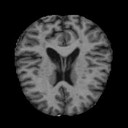

2. label = 0


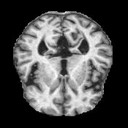

3. label = 3


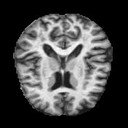

4. label = 3


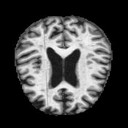

5. label = 2


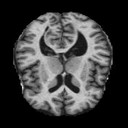

6. label = 2


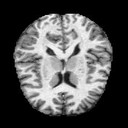

7. label = 2


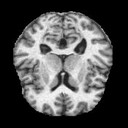

8. label = 2


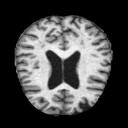

9. label = 3


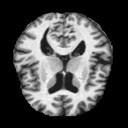

10. label = 2


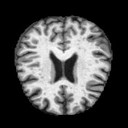

In [8]:
def display_images(df, n=10):
    """
    Display the first n grayscale images (numpy arrays) from df
    along with their labels. Assumes df has columns 'image' and 'label'.
    """
    for i, (_, row) in enumerate(df.head(n).iterrows(), start=1):
        pixels = row["image"]
        label = row.get("label", "")
        # Create a PIL image in 'L' mode (8-bit pixels, black and white)
        img = Image.fromarray(pixels.astype("uint8"), mode="L")
        print(f"{i}. label = {label}")
        display(img)
display_images(train_df)

#### Checking DATA frame Size

In [9]:
train_df.shape, test_df.shape


((5120, 2), (1280, 2))

### Check Level Distribution

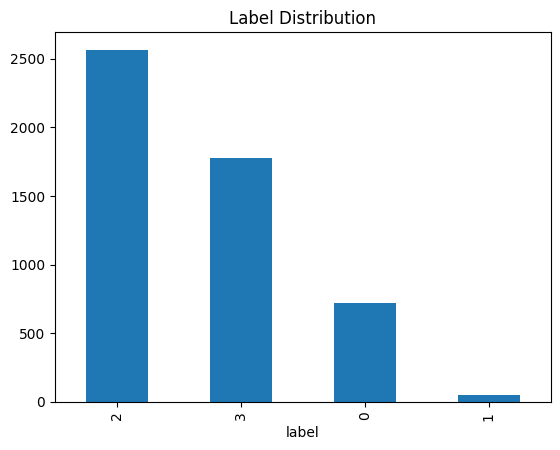

In [10]:
train_df['label'].value_counts().plot(kind='bar')
plt.title("Label Distribution")
plt.show()


 ### Show sample images per class


Class: 2


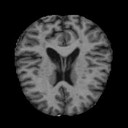

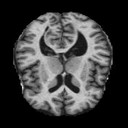

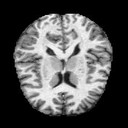


Class: 0


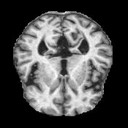

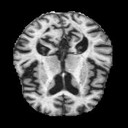

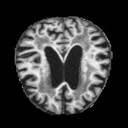


Class: 3


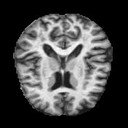

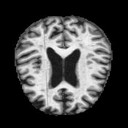

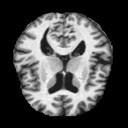


Class: 1


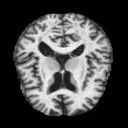

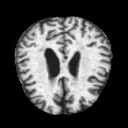

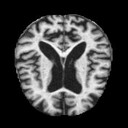

In [11]:
def show_samples_per_class(df, n=3):
    classes = df['label'].unique()
    for cls in classes:
        subset = df[df['label'] == cls].head(n)
        print(f"\nClass: {cls}")
        for i, row in subset.iterrows():
            display(Image.fromarray(row['image'].astype("uint8")))
            
show_samples_per_class(train_df)


## Image Preprocessing

In [12]:
import tensorflow as tf

IMG_SIZE = 128

def preprocess(img):
    img = Image.fromarray(img.astype("uint8")).resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=-1)  # grayscale channel
    return img

train_df["processed"] = train_df["image"].apply(preprocess)
test_df["processed"]  = test_df["image"].apply(preprocess)


### Train/Validation Split

In [13]:
from sklearn.model_selection import train_test_split

X = np.stack(train_df["processed"].values)
y = train_df["label"].values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_val.shape


((4096, 128, 128, 1), (1024, 128, 128, 1))

### Building Baseline CNN

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\sanir\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 826,436 (3.15 MB)

 Trainable params: 826,436 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

### Train Baseline Model

In [15]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)




Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5208 - loss: 0.9954 - val_accuracy: 0.5859 - val_loss: 0.8905
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5979 - loss: 0.8705 - val_accuracy: 0.6250 - val_loss: 0.7978
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6702 - loss: 0.7261 - val_accuracy: 0.7080 - val_loss: 0.6503
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7747 - loss: 0.5234 - val_accuracy: 0.7549 - val_loss: 0.5619
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8618 - loss: 0.3603 - val_accuracy: 0.8428 - val_loss: 0.3936
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9175 - loss: 0.2226 - val_accuracy: 0.8369 - val_loss: 0.3602
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9631 - loss: 0.1182 - val_accuracy: 0.9092 - val_loss: 0.3118
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9788 - loss: 0.0728 - val_accu

### Evaluate Your Model

#### Accuracy

In [16]:
val_loss, val_acc = model.evaluate(X_val, y_val)
val_acc


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9502 - loss: 0.1553


0.9501953125

#### Confusion Matrix

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


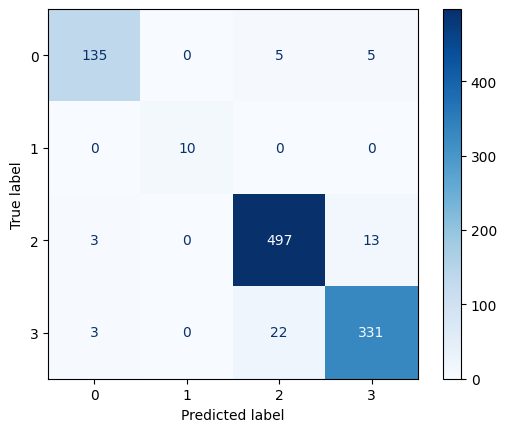

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = np.argmax(model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.show()


#### Classification Report

In [18]:
# Sometimes the issue is with le.classes_
print(f"le.classes_ type: {type(le.classes_)}")
print(f"le.classes_: {le.classes_}")

# Ensure classes are strings
target_names = [str(cls) for cls in le.classes_]

# Clean the y_val and preds
y_val_clean = np.array(y_val).ravel().astype(int)
preds_clean = np.array(preds).ravel().astype(int)

print(classification_report(y_val_clean, preds_clean, target_names=target_names))

le.classes_ type: <class 'numpy.ndarray'>
le.classes_: [0 1 2 3]


NameError: name 'classification_report' is not defined

## Transfer Learning + Augmentation

### Data Augmentation

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(factor=0.2),
], name="data_aug")


In [20]:
IMG_SIZE = 224

def preprocess_for_tl(img):
    # Ensure image has the right dimensions
    if len(img.shape) == 2:  # Grayscale (H, W)
        img = np.repeat(img[..., np.newaxis], 3, axis=-1)  # Convert to (H, W, 3)
    elif len(img.shape) == 3 and img.shape[-1] == 1:  # Grayscale with channel dim
        img = np.repeat(img, 3, axis=-1)
    # If already RGB (H, W, 3), leave as is
    
    # Resize
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

train_df["tl_img"] = train_df["image"].apply(lambda x: preprocess_for_tl(x))
test_df["tl_img"] = test_df["image"].apply(lambda x: preprocess_for_tl(x))

### Build Transfer Learning Model

### Recommended Model: EfficientNetB3


### EfficientNetB3 Transfer Learning Block

In [21]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(factor=0.2),
], name="data_aug")


### Train Phase 1 (Frozen)


In [29]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 224

def preprocess_for_tl(img):
    # convert numpy → tensor
    img = tf.convert_to_tensor(img, dtype=tf.float32)

    # grayscale (H, W, 1) → RGB (H, W, 3)
    img = tf.image.grayscale_to_rgb(img)

    # resize
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    # MobileNetV2 preprocessing
    img = preprocess_input(img)

    return img


In [31]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base.trainable = False   # Phase 1: Freeze extractor

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(len(le.classes_), activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
print(train_df["tl_img"].iloc[0].shape)
print(test_df["tl_img"].iloc[0].shape)


(224, 224, 3)
(224, 224, 3)


In [34]:
def add_channel(img):
    if img.ndim == 2:
        return np.expand_dims(img, axis=-1)
    return img

train_df["image"] = train_df["image"].apply(add_channel)
test_df["image"]  = test_df["image"].apply(add_channel)


In [35]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 224

def preprocess_for_tl(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)

    # grayscale → RGB safely
    img = tf.image.grayscale_to_rgb(img)

    # resize to 224×224
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    # normalize the way MobileNet expects
    img = preprocess_input(img)

    return img.numpy()   # important


In [36]:
train_df["tl_img"] = train_df["image"].apply(preprocess_for_tl)
test_df["tl_img"]  = test_df["image"].apply(preprocess_for_tl)


In [37]:
X = np.stack(train_df["tl_img"].values)
y = le.transform(train_df["label"].values)


In [38]:
print(X.shape)


(5120, 224, 224, 3)


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [40]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base.trainable = False   # Phase 1: Freeze extractor

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(len(le.classes_), activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train Phase 1 (Frozen)

In [41]:
history_1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 63s 448ms/step - accuracy: 0.4556 - loss: 1.1354 - val_accuracy: 0.5010 - val_loss: 1.0450
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 62s 481ms/step - accuracy: 0.4639 - loss: 1.1050 - val_accuracy: 0.5010 - val_loss: 1.0594
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 60s 472ms/step - accuracy: 0.4597 - loss: 1.0807 - val_accuracy: 0.5010 - val_loss: 1.0395
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 63s 493ms/step - accuracy: 0.4702 - loss: 1.0767 - val_accuracy: 0.5010 - val_loss: 1.0564
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 62s 485ms/step - accuracy: 0.4573 - loss: 1.0829 - val_accuracy: 0.5010 - val_loss: 1.0552
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 53s 412ms/step - accuracy: 0.4746 - loss: 1.0650 - val_accuracy: 0.5010 - val_loss: 1.0442
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 61s 478ms/step - accuracy: 0.4744 - loss: 1.0701 - val_accuracy: 0.5010 - val_loss: 1.0473
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 63s 490ms/step - accuracy: 0.4675 - loss: 1

### Fine-Tuning MobileNetV2

In [42]:
base.trainable = True

# Freeze lower layers, fine-tune the final block
for layer in base.layers[:-30]:
    layer.trainable = False


In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [44]:
history_2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 74s 528ms/step - accuracy: 0.4351 - loss: 1.3303 - val_accuracy: 0.3477 - val_loss: 1.0597
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 79s 620ms/step - accuracy: 0.4646 - loss: 1.0998 - val_accuracy: 0.3477 - val_loss: 1.0843
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 74s 581ms/step - accuracy: 0.4634 - loss: 1.0769 - val_accuracy: 0.3477 - val_loss: 1.1728
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 69s 539ms/step - accuracy: 0.4697 - loss: 1.0743 - val_accuracy: 0.3477 - val_loss: 1.2574
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 77s 603ms/step - accuracy: 0.4722 - loss: 1.0711 - val_accuracy: 0.3477 - val_loss: 1.2364
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 74s 581ms/step - accuracy: 0.4636 - loss: 1.0697 - val_accuracy: 0.3477 - val_loss: 1.1931
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 86s 673ms/step - accuracy: 0.4834 - loss: 1.0551 - val_accuracy: 0.3477 - val_loss: 1.1238
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 83s 647ms/step - accuracy: 0.4868 - loss: 1

### Evaluate

#### ROC Curves

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step


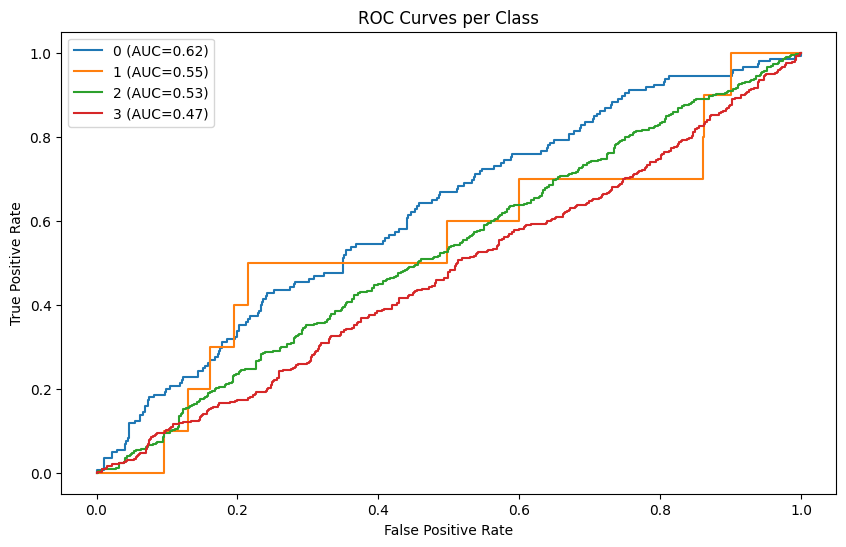

In [46]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_bin = label_binarize(y_val, classes=range(len(le.classes_)))
pred_prob = model.predict(X_val)

plt.figure(figsize=(10,6))
for i, cls in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_bin[:,i], pred_prob[:,i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc_score:.2f})")

plt.title("ROC Curves per Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## Grad-CAM for Keras (MobileNetV2) — robust helper

In [48]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import backend as K

def find_last_conv_layer(model):
    # return the name of the last Conv2D layer
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in model.")

def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name=None, class_index=None):
    """
    img_tensor: numpy array with shape (H,W,3) or (1,H,W,3)
    model: tf.keras.Model
    last_conv_layer_name: str or None (auto-detect if None)
    class_index: int or None (defaults to predicted class)
    returns: heatmap float32 (H,W) normalized to [0,1]
    """
    if img_tensor.ndim == 3:
        img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor = tf.convert_to_tensor(img_tensor, dtype=tf.float32)

    if last_conv_layer_name is None:
        last_conv_layer_name = find_last_conv_layer(model)

    # Build a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        [model.inputs], [last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    # Compute gradients of top predicted class w.r.t. conv layer outputs
    grads = tape.gradient(loss, conv_outputs)
    # Compute guided gradients (optional: use plain grads)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    pooled_grads = pooled_grads.numpy()
    conv_outputs = conv_outputs.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    # ReLU & normalize
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) == 0:
        return np.zeros_like(heatmap)
    heatmap /= np.max(heatmap)
    return heatmap


### Overlay heatmap over original grayscale MRI (save or display)

In [51]:
from matplotlib import cm
from PIL import Image

def overlay_heatmap_on_grayscale(gray_img, heatmap, alpha=0.5, colormap='viridis'):
    """
    gray_img: numpy array shape (H,W) or (H,W,1), dtype uint8 or float [0,1]
    heatmap: numpy array shape (h,w) normalized [0,1]
    returns: overlay image as uint8 RGB numpy array (H,W,3)
    """
    # Ensure gray is (H,W)
    if gray_img.ndim == 3 and gray_img.shape[-1] == 1:
        gray = gray_img[:, :, 0]
    else:
        gray = gray_img.copy()

    # Resize heatmap to gray size
    heatmap_resized = cv2.resize(heatmap, (gray.shape[1], gray.shape[0]))
    cmap = cm.get_cmap(colormap)
    heatmap_rgb = cmap(heatmap_resized)[:, :, :3]  # drop alpha

    # Normalize gray to [0,1]
    if gray.dtype != np.float32 and gray.dtype != np.float64:
        gray_norm = gray.astype("float32") / 255.0
    else:
        gray_norm = gray

    gray_stack = np.stack([gray_norm]*3, axis=-1)

    overlay = (1 - alpha) * gray_stack + alpha * heatmap_rgb
    overlay_uint8 = np.clip(overlay * 255.0, 0, 255).astype("uint8")
    return overlay_uint8

# Example display helper:
def show_gradcam_for_index(idx, X_input, y_true, original_gray_images, model, last_conv=None):
    """
    idx: index in X_val (or X_train) to explain
    X_input: the dataset used for inference (224,224,3, preprocessed for MobileNet)
    y_true: true label array
    original_gray_images: list/array of original grayscale images aligned with X_input (pre-resize optional)
    model: trained tf.keras Model
    """
    img = X_input[idx]  # preprocessed (MobileNet's preprocess_input already applied)
    pred_probs = model.predict(np.expand_dims(img, axis=0))[0]
    pred_class = np.argmax(pred_probs)
    true_class = y_true[idx]
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name=last_conv, class_index=pred_class)
    
    # Map back to original grayscale (if original images are not 224x224, resize them)
    orig = original_gray_images[idx]
    if isinstance(orig, np.ndarray) and orig.ndim == 2:
        orig_resized = cv2.resize(orig, (img.shape[1], img.shape[0]))
    elif isinstance(orig, np.ndarray) and orig.ndim == 3 and orig.shape[-1] == 1:
        orig_resized = cv2.resize(orig[:, :, 0], (img.shape[1], img.shape[0]))
    else:
        orig_resized = orig
    
    overlay = overlay_heatmap_on_grayscale(orig_resized, heatmap, alpha=0.5, colormap='jet')
    
    plt.figure(figsize=(10,4))
    plt.suptitle(f"True: {le.inverse_transform([true_class])[0]}  Pred: {le.inverse_transform([pred_class])[0]}")
    plt.subplot(1,3,1)
    plt.title("Original (resized)")
    plt.imshow(orig_resized, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title("Heatmap")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


### Visualize correct vs wrong predictions (batch)

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions
pred_probs = model.predict(X_val)
preds = np.argmax(pred_probs, axis=1)

# Check what's happening with predictions
print("Unique predictions:", np.unique(preds))
print("Prediction distribution:")
unique, counts = np.unique(preds, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

print("True label distribution:")
unique_true, counts_true = np.unique(y_val, return_counts=True)
for cls, count in zip(unique_true, counts_true):
    print(f"Class {cls}: {count} samples")

# Fix classification report - ensure target_names are strings
cm = confusion_matrix(y_val, preds)
print("Confusion matrix:\n", cm)

# Convert label encoder classes to strings for classification report
target_names = [str(cls) for cls in le.classes_]
print(classification_report(y_val, preds, target_names=target_names, zero_division=0))

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step
Unique predictions: [3]
Prediction distribution:
Class 3: 1024 samples
True label distribution:
Class 0: 145 samples
Class 1: 10 samples
Class 2: 513 samples
Class 3: 356 samples
Confusion matrix:
 [[  0   0   0 145]
 [  0   0   0  10]
 [  0   0   0 513]
 [  0   0   0 356]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       145
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00       513
           3       0.35      1.00      0.52       356

    accuracy                           0.35      1024
   macro avg       0.09      0.25      0.13      1024
weighted avg       0.12      0.35      0.18      1024



### Error analysis

In [54]:
import pandas as pd
# Per-class accuracy
report = classification_report(y_val, preds, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# Which classes are most confused?
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
display(cm_df)

# Show most confused pairs: sort off-diagonals
cm_mask = cm.copy().astype(float)
np.fill_diagonal(cm_mask, 0)
flat_idx = np.unravel_index(np.argsort(cm_mask.flatten())[::-1], cm_mask.shape)
top_pairs = list(zip(np.array(le.classes_)[flat_idx[0]], np.array(le.classes_)[flat_idx[1]], cm_mask.flatten()[np.argsort(cm_mask.flatten())[::-1]]))
print("Top confusion pairs (true -> predicted):")
for t, p, v in top_pairs[:6]:
    print(f"{t} -> {p}: {int(v)} cases")


c:\Users\sanir\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sanir\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sanir\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,145.000000
1,0.000000,0.000000,0.000000,10.000000
2,0.000000,0.000000,0.000000,513.000000
3,0.347656,1.000000,0.515942,356.000000
accuracy,0.347656,0.347656,0.347656,0.347656
macro avg,0.086914,0.250000,0.128986,1024.000000
weighted avg,0.120865,0.347656,0.179370,1024.000000


,0,1,2,3
0,0,0,0,145
1,0,0,0,10
2,0,0,0,513
3,0,0,0,356


Top confusion pairs (true -> predicted):
2 -> 3: 513 cases
0 -> 3: 145 cases
1 -> 3: 10 cases
3 -> 3: 0 cases
3 -> 0: 0 cases
2 -> 2: 0 cases


### Class imbalance check & remedy

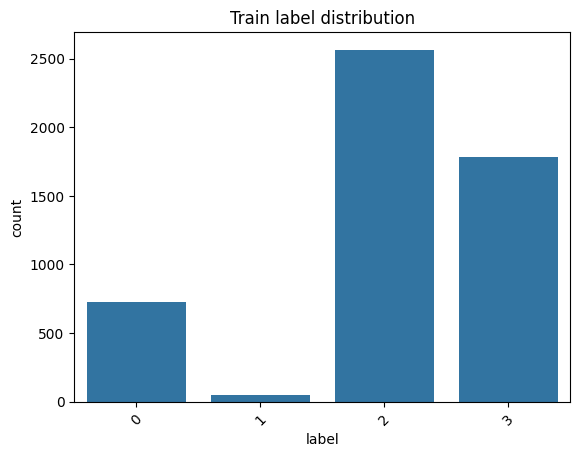

In [55]:
import seaborn as sns
sns.countplot(x=train_df['label'])
plt.title("Train label distribution")
plt.xticks(rotation=45)
plt.show()


### Remedies (practical & quick):


#### Class weights

In [56]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
cw = dict(enumerate(class_weights))
# model.fit(..., class_weight=cw)


#### Oversample minority classes

In [57]:
from sklearn.utils import resample
# Create new X_bal, y_bal by upsampling minority classes
X_resampled = []
y_resampled = []
for label in np.unique(y_train):
    X_label = X_train[y_train==label]
    y_label = y_train[y_train==label]
    n_max = max([(y_train==lab).sum() for lab in np.unique(y_train)])
    X_up = resample(X_label, replace=True, n_samples=n_max, random_state=42)
    y_up = np.full(n_max, label)
    X_resampled.append(X_up)
    y_resampled.append(y_up)
X_bal = np.vstack(X_resampled)
y_bal = np.concatenate(y_resampled)
# shuffle
perm = np.random.permutation(len(y_bal))
X_bal = X_bal[perm]; y_bal = y_bal[perm]


#### Focal Loss — penalize easy negatives

In [58]:
def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        y_true_ohe = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        ce = tf.keras.losses.categorical_crossentropy(y_true_ohe, y_pred, from_logits=False)
        p_t = tf.reduce_sum(y_true_ohe * y_pred, axis=-1)
        mod = (1 - p_t) ** gamma
        return tf.reduce_mean(alpha * mod * ce)
    return loss
# model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])


#### Improve model — augmentation & architecture tweaks

In [59]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.08),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.15),
])


In [60]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]  